In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import train_test_split, KFold

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
data.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
data.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

## Data preparation

In [4]:
data.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
categorical = ["lead_source", "industry", "employment_status", "location"]
numerical = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"]

data[categorical] = data[categorical].fillna("NA")
data[numerical] = data[numerical].fillna(0)

df_full_train, df_test = train_test_split(data, test_size=.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=.25, random_state=1)

## 1. ROC AUC for feature importance

In [6]:
scores = {}

for col in numerical:
    score = roc_auc_score(df_train['converted'], df_train[col])
    if score < 0.5:
        score = roc_auc_score(df_train['converted'], -df_train[col])
    scores[col] = score
    
scores

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

## 2. Training the model

In [7]:
vec = DictVectorizer(sparse=False)

X_train = vec.fit_transform(df_train.drop("converted", axis=1).to_dict(orient='records'))
y_train = df_train['converted']

X_val = vec.transform(df_val.drop("converted", axis=1).to_dict(orient="records"))
y_val = df_val['converted']

In [8]:
logreg = LogisticRegression(solver="liblinear", C=1, max_iter=1000)

logreg.fit(X_train, y_train)

probas = logreg.predict_proba(X_val)[:, 1]
y_pred = (probas >= 0.5)

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
round(auc(fpr, tpr), 3)

0.648

## 3. Precision and recall

In [9]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (probas >= t)
    predict_negative = (probas < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    scores.append((t, precision, recall))

columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

/tmp/ipykernel_40422/1365044702.py:17: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


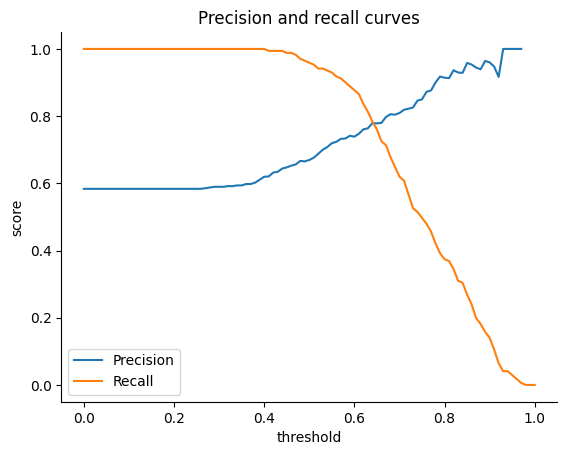

In [10]:
plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title("Precision and recall curves")
plt.show()

In [11]:
df_scores[abs(df_scores['precision'] - df_scores['recall']) < 0.01]

,threshold,precision,recall
64,0.64,0.77907,0.783626


## 4. F1 score

In [12]:
df_scores['f1'] = 2*(df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])

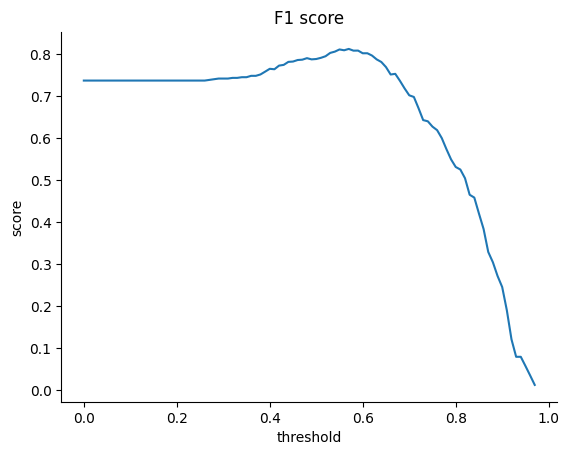

In [13]:
plt.plot(df_scores['threshold'], df_scores['f1'])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('F1 score')
plt.show()

In [14]:
df_scores.sort_values('f1', ascending=False).head(1)

,threshold,precision,recall,f1
57,0.57,0.732394,0.912281,0.8125


## 5. 5-Fold CV

In [15]:
def train_model(df_train: pd.DataFrame, y_train: pd.Series, C=1):
    vec = DictVectorizer(sparse=False)
    X_train = vec.fit_transform(df_train[categorical + numerical].to_dict(orient='records'))
    
    logreg = LogisticRegression(C=C, max_iter=1000, solver='liblinear')
    logreg.fit(X_train, y_train)

    return vec, logreg

def predict(df_val: pd.DataFrame, vectorizer: DictVectorizer, model: LogisticRegression):
    X_val = vectorizer.transform(df_val[categorical + numerical].to_dict(orient='records'))
    y_pred = model.predict_proba(X_val)[:, 1]

    return y_pred

In [16]:
kfold = KFold(5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['converted'].values
    y_val = df_val['converted'].values

    vec, logreg = train_model(df_train, y_train)
    y_pred = predict(df_val, vec, logreg)

    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

np.std(scores)

np.float64(0.03580711942905165)

## 6. Hyperparameter tuning

In [17]:
c_values = [0.000001, 0.001, 1]
kfold = KFold(5, shuffle=True, random_state=1)

for c in c_values:
    
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['converted'].values
        y_val = df_val['converted'].values

        vec, logreg = train_model(df_train, y_train, C=c)
        y_pred = predict(df_val, vec, logreg)

        score = roc_auc_score(y_val, y_pred)
        scores.append(score)

    print(f'For C = {c}: mean auc = {np.mean(scores):.3f}, std = {np.std(scores):.3f}')


For C = 1e-06: mean auc = 0.560, std = 0.024
For C = 0.001: mean auc = 0.867, std = 0.029
For C = 1: mean auc = 0.822, std = 0.036
